In [1]:
# TEMP: Import lagom
# Not useful once lagom is installed
import sys
sys.path.append('/home/zuo/Code/lagom/')

# Evolution strategies on test functions for optimization

## Test functions for optimization

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from lagom.core.es.test_functions import Rastrigin
from lagom.core.es.test_functions import Sphere
from lagom.core.es.test_functions import StyblinskiTang
from lagom.core.es.test_functions import HolderTable


def plot_contour(f, num_points=100):
    x = np.linspace(*f.search_domain, num=num_points)
    y = np.linspace(*f.search_domain, num=num_points)
    x, y = np.meshgrid(x, y)
    
    # Compute function values
    z = f([x, y])
    
    fig, ax = plt.subplots(1, 1)
    ax.contourf(x, y, z, cmap='jet')
    
    return fig

# Sometimes it needs to run cell twice to show figure
fig = plot_contour(Rastrigin())

## Naive version (No parallelization)

In [4]:
def solve(es_optimizer, max_iter, log_interval=1):
    """
    Solve
    
    Args:
        es_optimizer (ESOptimizer): ES optimizer
        max_iter (int): maximum number of iterations (generations)
        log_interval (int): log interval
    """
    list_best_f_val = []
    
    for i in range(max_iter):
        # Perform one iteration
        results = es_optimizer.step()
        
        # Logging
        best_f_val = results['best_f_val']
        list_best_f_val.append(best_f_val)
        if i == 0 or (i+1)%log_interval == 0:
            print(f'Objective function value at iteration #{i+1}: {best_f_val}')
    
    # Final logging
    best_param = results['best_param']
    print(f'# Local optimum discovered by ES solver: {best_param}')
    print(f'# Its objective function value: {best_f_val}')
    
    return list_best_f_val

In [5]:
import numpy as np

from lagom.core.es import ESOptimizer
from lagom.core.es import CMAES, OpenAIES


# Seeding
seed = 0
np.random.seed(seed)

all_es = {}
all_best_f_val = {}

# Create and record all ES algorithms
cmaes = CMAES(mu0=[3]*100, 
              std0=0.5, 
              popsize=12)
all_es['CMAES'] = cmaes

openaies = OpenAIES(mu0=[3]*100, 
                    std0=0.5, 
                    popsize=50, 
                    std_decay=0.999,
                    min_std=0.01, 
                    lr=1e-1, 
                    lr_decay=1.0, 
                    min_lr=1e-1, 
                    antithetic=False, 
                    rank_transform=False)
all_es['OpenAI ES'] = openaies

openaies = OpenAIES(mu0=[3]*100, 
                    std0=0.5, 
                    popsize=50, 
                    std_decay=0.999,
                    min_std=0.01, 
                    lr=1e-1, 
                    lr_decay=1.0, 
                    min_lr=1e-1, 
                    antithetic=True, 
                    rank_transform=False)
all_es['OpenAI ES with antithetic'] = openaies

openaies = OpenAIES(mu0=[3]*100, 
                    std0=0.5, 
                    popsize=50, 
                    std_decay=0.999,
                    min_std=0.01, 
                    lr=1e-1, 
                    lr_decay=1.0, 
                    min_lr=1e-1, 
                    antithetic=False, 
                    rank_transform=True)
all_es['OpenAI ES with rank'] = openaies

openaies = OpenAIES(mu0=[3]*100, 
                    std0=0.5, 
                    popsize=50, 
                    std_decay=0.999,
                    min_std=0.01, 
                    lr=1e-1, 
                    lr_decay=1.0, 
                    min_lr=1e-1, 
                    antithetic=True, 
                    rank_transform=True)
all_es['OpenAI ES with antithetic and rank'] = openaies

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 100 (seed=333429, Tue Jul 10 13:38:32 2018)


In [6]:
from time import time


t = time()

for name, es in all_es.items():
    print('#'*50)
    print(f'ES: {name}')
    print('#'*50)
    
    es_optimizer = ESOptimizer(es, Rastrigin())

    list_best_f_val = solve(es_optimizer=es_optimizer, 
                            max_iter=1000, 
                            log_interval=100)
    
    all_best_f_val[name] = list_best_f_val

print(f'Total time: {time() - t:.3} s')

##################################################
ES: CMAES
##################################################
Objective function value at iteration #1: 1695.5462160902916
Objective function value at iteration #100: 1601.5689251188344
Objective function value at iteration #200: 1240.487321490478
Objective function value at iteration #300: 1182.7154196603278
Objective function value at iteration #400: 1132.9732928900758
Objective function value at iteration #500: 625.625996579403
Objective function value at iteration #600: 477.062937639156
Objective function value at iteration #700: 469.08499559369193
Objective function value at iteration #800: 468.66499713288346
Objective function value at iteration #900: 468.62607465945985
Objective function value at iteration #1000: 468.6236789923834
# Local optimum discovered by ES solver: [-9.95066743e-01  9.94931305e-01  1.98976932e+00 -2.98476330e+00
  2.98490525e+00 -4.20814145e-05 -1.98985495e+00 -1.99003049e+00
  9.94914370e-01  2.98489551e+0

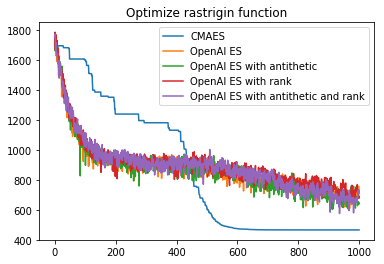

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1)

for name, best_f_val in all_best_f_val.items():
    ax.plot(best_f_val, label=f'{name}')

ax.set_title('Optimize rastrigin function')
ax.legend()

## Parallelized ES

In [3]:
from lagom.core.es import CMAES, OpenAIES

from lagom.core.es.test_functions import Rastrigin

from lagom.core.es import BaseESWorker
from lagom.core.es import BaseESMaster


class ESWorker(BaseESWorker):
    def f(self, solution, seed):
        rastrigin = Rastrigin()
        
        function_value = rastrigin(solution)
        
        return function_value
    

class ESMaster(BaseESMaster):
    def make_es(self):
        cmaes = CMAES(mu0=[3]*100, 
                      std0=0.5, 
                      popsize=12)
        
        return cmaes
        
    def _process_es_result(self, result):
        best_f_val = result['best_f_val']
        if self.generation == 0 or (self.generation+1) % 100 == 0:
            print(f'Best function value at generation {self.generation+1}: {best_f_val}')
            
            
            
es = ESMaster(num_iteration=1000, 
              worker_class=ESWorker, 
              num_worker=12, 
              init_seed=0, 
              daemonic_worker=None)

es()

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 100 (seed=468908, Wed Jul 11 17:30:40 2018)
Best function value at generation 1: 1807.1865231790885
Best function value at generation 100: 1523.6579993208045
Best function value at generation 200: 1361.3707354448763
Best function value at generation 300: 1305.5439537103764
Best function value at generation 400: 1207.6983724025765
Best function value at generation 500: 1059.917203872674
Best function value at generation 600: 668.1869760573895
Best function value at generation 700: 482.120220088945
Best function value at generation 800: 464.92558395242185
Best function value at generation 900: 463.7092978098449
Best function value at generation 1000: 463.65244047292987
